# Supervised Instruct-tuning OpenLLaMA Using Dolly15k Dataset

Tools/Libraries:
- [Hugging Face's PEFT Library](https://github.com/huggingface/peft)
- [Hugging Face's Transformers Library](https://huggingface.co/docs/transformers/index)
- [QLoRA](https://arxiv.org/abs/2305.14314)
- [TRL](https://github.com/lvwerra/trl/tree/main/docs/source)

In [1]:
!pip install transformers==4.31.0
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

https://www.youtube.com/watch?v=eTieetk2dSw\

https://github.com/FourthBrain/Building-with-Instruction-Tuned-LLMs-A-Step-by-Step-Guide
https://colab.research.google.com/drive/1SRclU2pcgzCkVXpmhKppVbGW4UcCs5xT?usp=sharing#scrollTo=FuXIFTFapAMI


In [2]:
from datasets import load_dataset

dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Visualizing the Data (Dolly15k)


In [3]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [4]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 2200:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

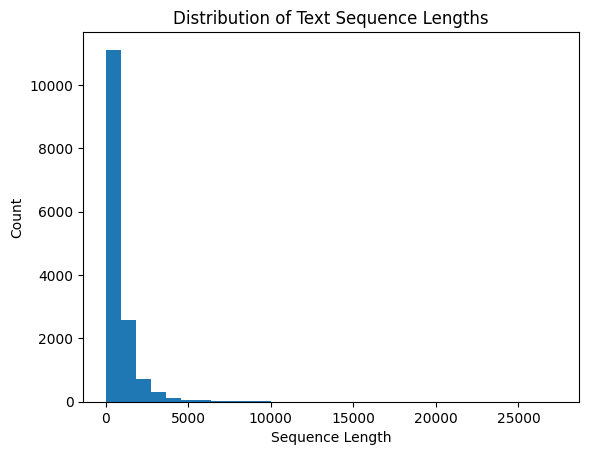

In [5]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

Some of these sequences are too long. Let's eliminate the ones above 2200 characters.


In [6]:
len(indexes_to_drop)

936

In [7]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indexes_to_drop)
)

Parameter 'indices'=<generator object <genexpr> at 0x78fc84e2eff0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [8]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14075
})

In [9]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size=0.1)

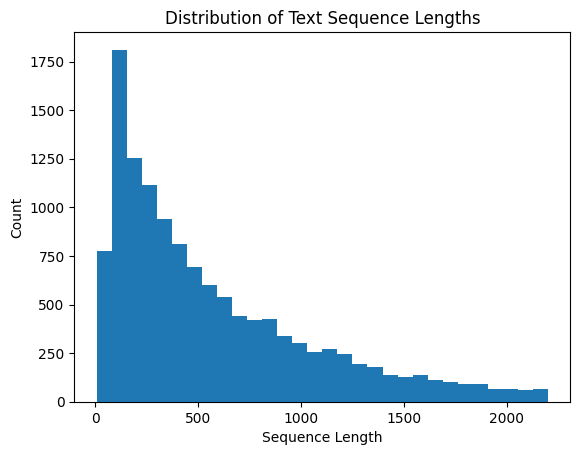

In [10]:
indexes_to_drop = plot_sequence_lengths(dbricks_15k_dataset_prepared)

In [11]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})

Prior to beginning training, we set up some helper functions that ensure our data is parsed in the desired format. Then, we save our PEFT (Parameter-Efficient Fine-Tuning) adapters.

In [12]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [13]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [14]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})

In [15]:
formatted_dataset["train"][2]["text"]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat did Stryk study at the Technical University of Munich?\n\n### Input: \nFrom 1984 to 1989 Stryk studied mathematics and computer science at the Technical University of Munich. In 1994 he received his doctorate in mathematics and then habilitated at the university. He was then postdoctoral researcher at TU Munich. Since 2000 he is professor of simulation, system optimization and robotics at the department of computer science of the Technische Universität Darmstadt. From April 2011 to March 2013 he was dean of the department. He was visiting professor and lecturer at the University of California, San Diego, and the Universidade Estadual de Campinas, Brazil. Stryk is vice president of Robocup. Since 2018 he has been building the German Rescue Robotics Centre.\n\n### Response: \nStryk studied mathematics and 

We have now parsed Dolly15k down to a reasonable length. Let's set up the ML model.

Here, we will leverage QLoRA. This will ensure we use a lower amount of memory during fine-tuning. The basic idea of the paper is that for a more downstream task, less parameters need to be tuned. We can be efficient!

[Read more](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

We'll train on the Open LLaMA 7-billion parameter version.

In [17]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b"

qlora_config = LoraConfig(
    r=16, # rank in QLoRA paper
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [18]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # add special token , [PAD]

tokenizer.model:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

1

In [19]:
print(base_model) # want everything in 4bit. check layers. remember -- only finetuning q and v

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Now, let's set up our SupervisedFineTuningTrainer

More information on the SFTTrainer:

- [HF Documentation](https://huggingface.co/docs/trl/main/en/sft_trainer)
- [Repository](https://github.com/lvwerra/trl/blob/main/trl/trainer/sft_trainer.py)

In [20]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=5000,
        output_dir="./SFTOpenLM-Dolly15k",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [21]:
supervised_finetuning_trainer.train()

Step,Training Loss
500,1.255800
1000,1.216400
1500,1.219200
2000,1.193300
2500,1.220400
3000,1.216200
3500,1.164200
4000,1.147700
4500,1.130900
5000,1.126500


TrainOutput(global_step=5000, training_loss=1.1890663818359375, metrics={'train_runtime': 7679.2144, 'train_samples_per_second': 2.604, 'train_steps_per_second': 0.651, 'total_flos': 7.061987351846093e+16, 'train_loss': 1.1890663818359375, 'epoch': 1.58})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Save model weights
model_weights_path = 'base_model_weights.bin'
torch.save(base_model.state_dict(), model_weights_path)

# Save configuration if necessary
model_config_path = 'config.json'
with open(model_config_path, 'w') as f:
    f.write(base_model.config.to_json_string())

!zip model_files.zip base_model_weights.bin config.json

from google.colab import files

files.download('model_files.zip')

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("tomaszj321/Instruct-Tuning-LLM")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "tomaszj321/Instruct-Tuning-LLM"  # Replace with your model's name on Hugging Face
og_model = "openlm-research/open_llama_7b"
tokenizer = LlamaTokenizer.from_pretrained(og_model)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_id = "tomaszj321/Instruct-Tuning-LLM"
og_model = "openlm-research/open_llama_7b"
tokenizer = LlamaTokenizer.from_pretrained(og_model)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModel.from_pretrained(model_id)

Let's reload the model and try to use it!


In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

# Load the configuration from your config.json file
config = AutoConfig.from_pretrained("/content/config.json")

# Initialize the model with your configuration
model = AutoModelForCausalLM.from_config(config)

# Load the model weights from base_model_weights.bin
model.load_state_dict(torch.load("/content/base_model_weights.bin"))

# Ensure the model is on the correct device, e.g., CUDA if using GPU
model = model.to("cuda:0")


In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("tomaszj321/Instruct-Tuning-LLM")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("tomaszj321/Instruct-Tuning-LLM")
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

In [ ]:
from transformers import AutoModelForCausalLM

# Load the pre-fine-tuned (original) base model
model = AutoModelForCausalLM.from_pretrained('openlm-research/open_llama_7b').to("cuda:0")

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = base_model.generate(**inputs, max_new_tokens=200)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
  outputs = model.generate(**inputs, max_new_tokens=50)
  print("---- NON-INSTRUCT-TUNED-MODEL ----")
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

In [ ]:
make_inference("Convert the text into a dialogue between two characters.", "Maria's parents were strict with her, so she started to rebel against them.")